[![Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/anonym-gm/asplenia_EHR_embedding/blob/main/embedding_INA.ipynb)

## Libraries

In [16]:
import torch
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter(action='ignore')
import numpy as np
from sklearn.metrics import (
    matthews_corrcoef, confusion_matrix, accuracy_score, roc_auc_score,
    precision_score, recall_score, f1_score
)
import lightgbm as lgb
import seaborn as sns
from tqdm.notebook import tqdm
import sys, os
import random
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"       # to force BERT determinsm

def set_seed(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # per multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)


## Download data

In [17]:
!git clone https://github.com/anonym-gm/asplenia_EHR_embedding.git
%cd asplenia_EHR_embedding

Cloning into 'asplenia_EHR_embedding'...
remote: Enumerating objects: 134, done.
remote: Counting objects: 100% (134/134), done.
remote: Compressing objects: 100% (94/94), done.
remote: Total 134 (delta 61), reused 102 (delta 38), pack-reused 0 (from 0)
Receiving objects: 100% (134/134), 1.64 MiB | 5.34 MiB/s, done.
Resolving deltas: 100% (61/61), done.
/Users/maurizio/Library/CloudStorage/GoogleDrive-maurizio.giordano@icar.cnr.it/.Trash/asplenia_EHR_embedding/asplenia_EHR_embedding


## Load dataset

In [18]:
datapath = 'data'
lang = 'EN'
df = pd.read_json(os.path.join(datapath, f"dataset_{lang}.json")).set_index("id")
groupname = "ALL"
selected_ids = pd.read_csv(os.path.join(datapath, f"{groupname}_index.csv"), header=None).values.ravel()
num_epochs = 10
batch_size = 32
embedding_dim = 64
hidden_dim = 128
seed = 42
enable_plot = True
methods=['BINARY', 'DOME', 'LSTM', 'tLSTM', 'GRU', 'GRU-D', 'BEHRT', 'RETAIN', 'Dipole']
dataset = df.loc[selected_ids]
dataset

,is_splenectomized?,qt_vax_prophylaxis,days_after,days_before,qt_vax_post_prophylaxis,tsh,dosage_num,qt_vax_totali,smoking,dyslipidemia,...,splenectomy_indication,splenectomy_method,primary_disease,prophylaxis_vax_hib,prophylaxis_vax_flu,prophylaxis_vax_meningo,prophylaxis_vax_pneumo,splenectomy_response,gender,events
id,,,,,,,,,,,,,,,,,,,,,
1,1,0,0.0,0.0,5,NaN,-1000.0,4,0.0,0.0,...,NaN,0.0,2,0,0,0,0,NaN,0,"[{'type': 'therapy', 'event': 'antiplatelet ag..."
4,1,6,0.0,0.0,2,NaN,-1000.0,8,0.0,0.0,...,NaN,1.0,0,1,0,1,1,NaN,1,"[{'type': 'vaccination', 'event': 'Hib', 'date..."
8,1,0,0.0,0.0,1,NaN,-1000.0,1,0.0,0.0,...,NaN,0.0,7,0,0,0,0,NaN,1,"[{'type': 'surgical operation', 'event': 'sple..."
9,1,3,0.0,0.0,1,NaN,-1000.0,4,0.0,0.0,...,NaN,0.0,2,1,0,1,1,NaN,0,"[{'type': 'vaccination', 'event': 'Hib', 'date..."
10,1,3,0.0,0.0,0,NaN,-1000.0,3,0.0,0.0,...,NaN,0.0,0,1,0,1,1,NaN,0,"[{'type': 'therapy', 'event': 'anticoagulant',..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1948,1,11,0.0,0.0,0,NaN,-1000.0,11,0.0,0.0,...,NaN,NaN,0,1,0,1,1,NaN,1,"[{'type': 'vaccination', 'event': 'Hib', 'date..."
1949,1,9,0.0,0.0,0,NaN,-1000.0,9,0.0,0.0,...,NaN,NaN,0,1,0,1,1,NaN,1,"[{'type': 'vaccination', 'event': 'PCV13', 'da..."
1950,1,9,0.0,0.0,0,NaN,-1000.0,9,0.0,0.0,...,NaN,NaN,0,1,0,1,1,NaN,1,"[{'type': 'vaccination', 'event': 'Hib', 'date..."


## Get sequences and static data

In [19]:
from src.utils import count_events_by_type
ev_fields = ['event']
target_type = "infection"
events_field, date_field, type_field = 'events', 'date', 'type'
removeevents = ['followup', 'platelet_change']
attributes = pd.read_csv(os.path.join(datapath, "attributes_EN.csv"), header=None, comment = '#', index_col=0).index.to_list()
event_sequences_no_trunc_with_type = { id: [(" ".join([event[field] for field in ev_fields]), event[date_field], event[type_field]) for event in events] for (id,events) in dataset[[events_field]].to_dict()[events_field].items()} 
cnt_df = count_events_by_type(event_sequences_no_trunc_with_type)

In [20]:
from src.utils import group_events_by_visit
# get sequence of event names
event_sequences_no_trunc_with_type = { id: [(" ".join([event[field] for field in ev_fields]), event[date_field], event[type_field]) for event in events if event[type_field] not in removeevents] for (id,events) in dataset[[events_field]].to_dict()[events_field].items()} 
event_sequences_no_trunc = { id: [(" ".join([event[field] for field in ev_fields]), event[date_field]) for event in events if event[type_field] not in removeevents] for (id,events) in dataset[[events_field]].to_dict()[events_field].items()} 
visit_sequences_no_trunc = group_events_by_visit(event_sequences_no_trunc)
print(f"n.{len(event_sequences_no_trunc)} Patients")


n.1067 Patients


## Load targets

In [21]:
targets = list(cnt_df.loc[target_type]['set'])
targets

['bacterial/viral infection of the ear',
 'sexually transmitted viral infection',
 'viral infection of the respiratory tract',
 'viral/automimetic infection of the eye',
 'bacterial infection of the bones',
 'bacterial/viral infection of the gastrointestinal system',
 'viral infection',
 'bacterial infection of the pleural cavities',
 'viral infection of the liver',
 'bacterial infection of the breast',
 'bacterial/viral infection of the oral mucous membranes',
 'bacterial streptococcal infection',
 'bacterial/viral infection of the respiratory tract',
 'bacterial infection of the urinary tract',
 'bacterial/viral infection of the central nervous system',
 'bacterial infection of the soft tissues',
 'bacterial/viral infection of the joints',
 'systemic viral infection',
 'bacterial/viral infection of the pancreas',
 'systemic parasitic infection',
 'viral infection of the skin and mucous membranes',
 'zoonotic bacterial infection',
 'bacterial infection of the respiratory tract',
 'loc

In [22]:
from src.utils import count_events_by_type
count_events_by_type(event_sequences_no_trunc_with_type)

,cardinality,n. instances,set
type,,,
therapy,34,3831,"{antipsychotic, vasodilator, antiviral, antihy..."
surgical operation,13,1129,"{kidney transplant, adenoidectomy, cholecystec..."
vaccination,8,4589,"{Hib, meningococcus_C, meningococcus_B, PCV7, ..."
infection,37,346,"{bacterial/viral infection of the ear, sexuall..."
comorbidity,15,647,"{nervous system diseases, cardiovascular disea..."
thrombosis,4,160,"{thromboembolism, venous thrombosis, arterial/..."


## Truncate sequences on 1st target

In [23]:
from src.utils import truncate_events_on1st_infection
event_sequences, y_df = truncate_events_on1st_infection(event_sequences_no_trunc_with_type, field_value=target_type)
visit_sequences = group_events_by_visit(event_sequences)

Truncating:   0%|          | 0/1067 [00:00<?, ?it/s]

## Configurations

In [24]:
from src.embedding import LSTMembedder, BEHRTembedder, COUNTEREmbedder, TimeAwareLSTMEmbedder, DipoleEmbedder 
from src.embedding import StaticEmbedder, RETAINembedder, DOMEEmbedder, BINARYEmbedder, GRUEmbedder, GRUEDembedder
# Definisci la lista dei "parametri" degli embedder
# === LSTM vcabulary ===
vocab = set()
for patient_events in event_sequences_no_trunc.values():
    for event,date in patient_events:
        vocab.update([event] if isinstance(event, str) else event)
word_to_idx = {word: idx for idx, word in enumerate(sorted(vocab))}  # for LSTM, RETAIN, etc
# === BEHRT vocabulary ===
code2id = {"[PAD]": 0, "[CLS]": 1, "[SEP]": 2}
idx = 3
for pid, visits in visit_sequences_no_trunc.items():
    for events, date in visits:
        for event in events:
            if event not in code2id:
                code2id[event] = idx
                idx += 1

labels = y_df.to_dict()['target']
embedder_configs =  { 
        "LSTM" : 
        {   "func": LSTMembedder,
            "kwargs": {
                "sequences": event_sequences,
                "labels": labels,
                "word_to_idx": word_to_idx,
                "num_epochs": num_epochs,
                "batch_size": batch_size,
                "embed_size": embedding_dim,
                "hidden_size": hidden_dim,
                "enable_plot": enable_plot
            }
        },
      "tLSTM" : 
        {   "func": TimeAwareLSTMEmbedder,
            "kwargs": {
                "sequences": event_sequences,
                "labels": labels,
                "word_to_idx": word_to_idx,
                "num_epochs": num_epochs,
                "batch_size": batch_size,
                "embed_size": embedding_dim,
                "hidden_size": hidden_dim,
                "enable_plot": enable_plot
            }
        },
      "RETAIN" : 
        {   "func": RETAINembedder,
            "kwargs": {
                "sequences": visit_sequences,
                "labels": labels,
                "word_to_idx": code2id,
                "num_epochs": num_epochs,
                "batch_size": batch_size,
                "embed_size": embedding_dim,
                "hidden_size": hidden_dim,
                "enable_plot": enable_plot
            }
        },
      "BEHRT" : 
        {   "func": BEHRTembedder,
            "kwargs": {
                "sequences": visit_sequences,
                "labels": labels,
                "word_to_idx": code2id,
                "num_epochs": num_epochs,
                "batch_size": batch_size,
                "embed_size": embedding_dim,
                "hidden_size": hidden_dim,
                "enable_plot": enable_plot
            }
        },
      "Dipole" : 
        {   "func": DipoleEmbedder,
            "kwargs": {
                "sequences": event_sequences,
                "labels": labels,
                "word_to_idx": code2id,
                "num_epochs": num_epochs,
                "batch_size": batch_size,
                "embed_size": embedding_dim,
                "hidden_size": hidden_dim,
                "enable_plot": enable_plot
            }
        },
        "GRU" : 
        {   "func": GRUEmbedder,
            "kwargs": {
                "sequences": event_sequences,
                "labels": labels,
                "word_to_idx": word_to_idx,
                "num_epochs": num_epochs,
                "batch_size": batch_size,
                "embed_size": embedding_dim,
                "hidden_size": hidden_dim,
                "enable_plot": enable_plot
            }
        },       "GRU-D" : 
        {   "func": GRUEDembedder,
            "kwargs": {
                "sequences": visit_sequences,
                "labels": labels,
                "word_to_idx": code2id,
                "num_epochs": num_epochs,
                "batch_size": batch_size,
                "embed_size": embedding_dim,
                "hidden_size": hidden_dim,
                "enable_plot": enable_plot
            }
        },
       "STATIC" : 
        {   "func": StaticEmbedder,
            "kwargs": {
                "df": dataset,
                "include_attributes": attributes,
                "enable_plot": enable_plot
            }
        },
      "DOME" :
        {
            "func": DOMEEmbedder,
            "kwargs": {
                 "sequences": event_sequences_no_trunc,
                 "targets": targets,
                 "df": dataset,
                 "enable_plot": enable_plot
            }
        },
        "BINARY": 
        {
            "func": BINARYEmbedder,
            "kwargs": {
                "sequences": event_sequences,
                "targets": targets,
                "vocab": vocab,
                "enable_plot": enable_plot
            }
        },
        "COUNTER": 
        {
            "func": COUNTEREmbedder,
            "kwargs": {
                "sequences": event_sequences,
                "targets": targets,
                "vocab": vocab,
                "enable_plot": enable_plot
            }
        }
    }


## Validate

In [9]:
from src.cv_folding import lgbm_cv
set_seed(seed)
results_df, model, _,_,_,_ = lgbm_cv(embedder_configs, y_df, selected_ids, methods=["STATIC"])
for m in methods:
    set_seed(seed)
    results_tmp, model, _,_,_,_ = lgbm_cv(embedder_configs, y_df, selected_ids, methods=["STATIC", m])
    results_df = pd.concat([results_df, results_tmp],axis=0)
results_df

,AUC mean,AUC std,F1 mean,F1 std,Prec mean,Prec std,Recall mean,Recall std,MCC mean,MCC std,Acc mean,Acc std,CM
STATIC,0.851709,0.028768,0.641487,0.048359,0.702981,0.125349,0.626087,0.125561,0.565240,0.042789,0.852850,0.013545,"[[766, 71], [86, 144]]"
STATIC+BINARY,0.848326,0.049965,0.683499,0.060926,0.740196,0.095589,0.643478,0.066793,0.608895,0.078758,0.870703,0.031119,"[[781, 56], [82, 148]]"
STATIC+DOME,0.851709,0.028768,0.641487,0.048359,0.702981,0.125349,0.626087,0.125561,0.565240,0.042789,0.852850,0.013545,"[[766, 71], [86, 144]]"
STATIC+LSTM,0.800187,0.050324,0.645361,0.057579,0.790835,0.026457,0.547826,0.073271,0.585899,0.058528,0.871625,0.015955,"[[804, 33], [104, 126]]"
STATIC+tLSTM,0.788634,0.075724,0.567381,0.149685,0.720458,0.055512,0.508696,0.187310,0.507639,0.110896,0.848186,0.022372,"[[788, 49], [113, 117]]"
STATIC+GRU,0.776916,0.066134,0.571443,0.103103,0.566174,0.119076,0.591304,0.134291,0.456388,0.130699,0.810710,0.042614,"[[729, 108], [94, 136]]"
STATIC+GRU-D,0.828646,0.050798,0.654143,0.102921,0.853608,0.069689,0.539130,0.123282,0.614279,0.103109,0.880988,0.027371,"[[816, 21], [106, 124]]"
STATIC+BEHRT,0.813354,0.052171,0.633552,0.106196,0.766318,0.095018,0.543478,0.113377,0.569282,0.120778,0.866926,0.033880,"[[800, 37], [105, 125]]"
STATIC+RETAIN,0.778236,0.037370,0.564837,0.073909,0.763970,0.144389,0.469565,0.099716,0.508881,0.070854,0.847225,0.022952,"[[796, 41], [122, 108]]"
STATIC+Dipole,0.769866,0.063485,0.573299,0.098761,0.804273,0.062425,0.456522,0.117472,0.531028,0.087672,0.858492,0.022023,"[[811, 26], [125, 105]]"


## Latex tables 5-6 in the paper

In [10]:
from src.utils import df_to_latex_bold
print(df_to_latex_bold(results_df))

\begin{tabular}{llllllll}
\toprule
 & AUC & F1 & Prec & Recall & MCC & Acc & CM \\
\midrule
STATIC & \textbf{0.852$\pm$0.029} & 0.641$\pm$0.048 & 0.703$\pm$0.125 & 0.626$\pm$0.126 & 0.565$\pm$0.043 & 0.853$\pm$0.014 & [[766  71]
 [ 86 144]] \\
STATIC+BINARY & 0.848$\pm$0.050 & \textbf{0.683$\pm$0.061} & 0.740$\pm$0.096 & \textbf{0.643$\pm$0.067} & 0.609$\pm$0.079 & 0.871$\pm$0.031 & [[781  56]
 [ 82 148]] \\
STATIC+DOME & \textbf{0.852$\pm$0.029} & 0.641$\pm$0.048 & 0.703$\pm$0.125 & 0.626$\pm$0.126 & 0.565$\pm$0.043 & 0.853$\pm$0.014 & [[766  71]
 [ 86 144]] \\
STATIC+LSTM & 0.800$\pm$0.050 & 0.645$\pm$0.058 & 0.791$\pm$0.026 & 0.548$\pm$0.073 & 0.586$\pm$0.059 & 0.872$\pm$0.016 & [[804  33]
 [104 126]] \\
STATIC+tLSTM & 0.789$\pm$0.076 & 0.567$\pm$0.150 & 0.720$\pm$0.056 & 0.509$\pm$0.187 & 0.508$\pm$0.111 & 0.848$\pm$0.022 & [[788  49]
 [113 117]] \\
STATIC+GRU & 0.777$\pm$0.066 & 0.571$\pm$0.103 & 0.566$\pm$0.119 & 0.591$\pm$0.134 & 0.456$\pm$0.131 & 0.811$\pm$0.043 & [[729 108]
 [

In [11]:
outpath = "output"
results_df.to_csv(os.path.join(outpath, f"results_ina_{groupname}.csv"))

## SHAP analysis

In [12]:
from src.cv_folding import lgbm_cv
results_df, model, X_df, Xv_df, y_train, y_test = lgbm_cv(embedder_configs, y_df, selected_ids, methods=["STATIC", "BINARY"])
results_df

,AUC mean,AUC std,F1 mean,F1 std,Prec mean,Prec std,Recall mean,Recall std,MCC mean,MCC std,Acc mean,Acc std,CM
STATIC+BINARY,0.848326,0.049965,0.683499,0.060926,0.740196,0.095589,0.643478,0.066793,0.608895,0.078758,0.870703,0.031119,"[[781, 56], [82, 148]]"


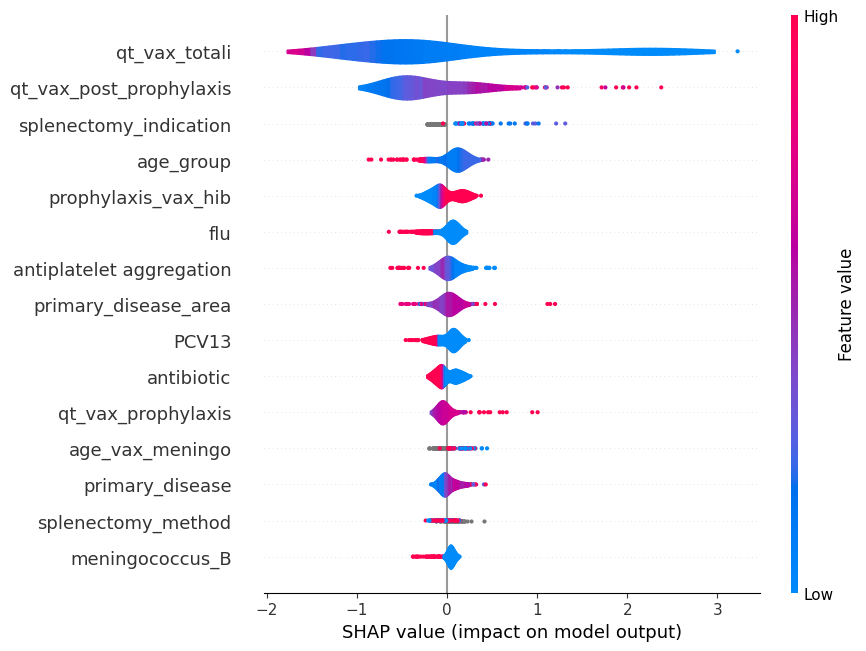

In [13]:
import shap
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(Xv_df)
shap.plots.violin(shap_values, features=Xv_df, feature_names=Xv_df.columns,max_display=15)


## Heatmaps

In [14]:
from src.cv_folding import lgbm_cv
results_df, model, X_df, Xv_df, y_train, y_test = lgbm_cv(embedder_configs, y_df, selected_ids, methods=["COUNTER"])
results_df

,AUC mean,AUC std,F1 mean,F1 std,Prec mean,Prec std,Recall mean,Recall std,MCC mean,MCC std,Acc mean,Acc std,CM
COUNTER,0.781927,0.063726,0.581998,0.103127,0.635624,0.081553,0.578261,0.170953,0.49422,0.087661,0.831315,0.021512,"[[754, 83], [97, 133]]"


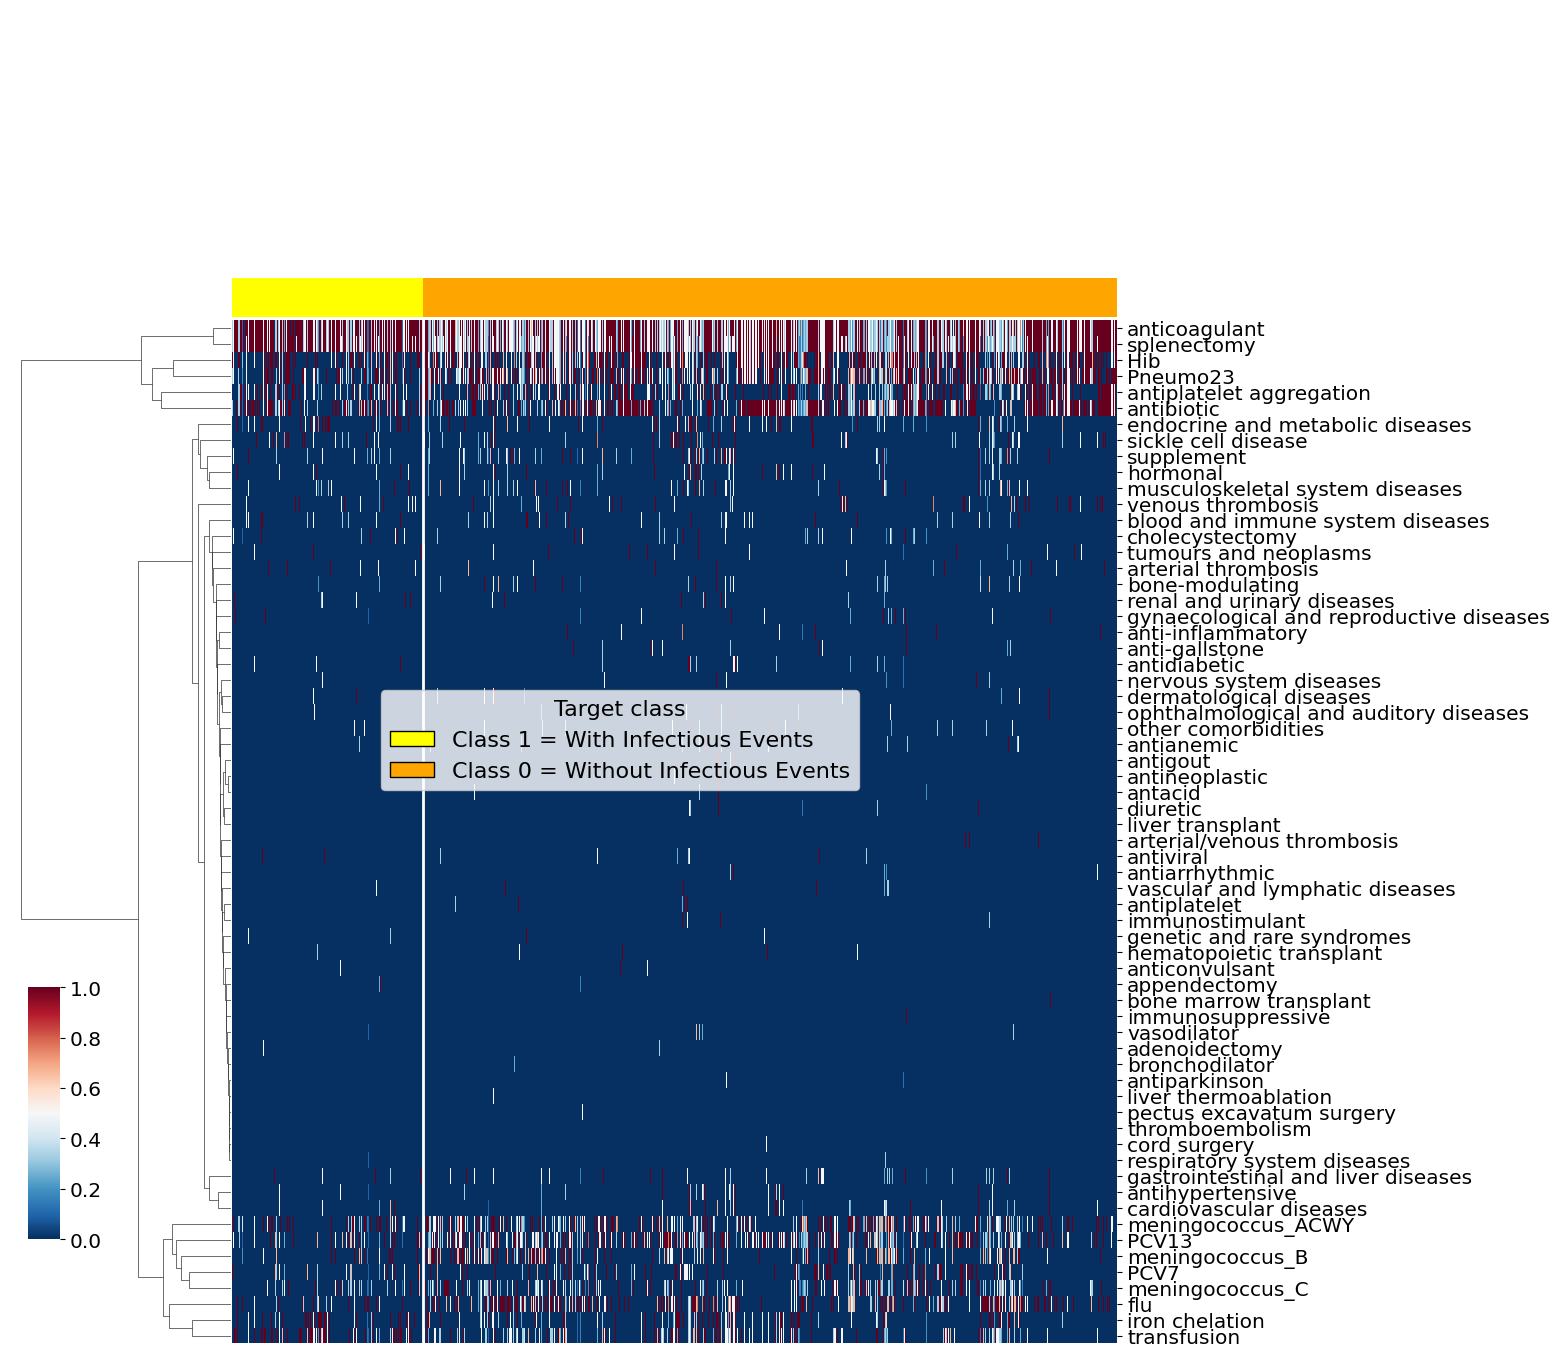

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
import matplotlib as mpl

mpl.rcParams['font.size'] = 20
mpl.rcParams['axes.titlesize'] = 22
mpl.rcParams['axes.labelsize'] = 22
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 14.5
mpl.rcParams['legend.fontsize'] = 16
mpl.rcParams['legend.title_fontsize'] = 16
X_df_all = pd.concat([X_df, Xv_df], axis=0)
X_df_all['target'] = y_df.loc[X_df_all.index, 'target']
X_sorted = X_df_all.sort_values('target', ascending=False)
targets_sorted = X_sorted['target'].values
X_sorted = X_sorted.drop(columns='target')
X_norm = X_sorted.copy()
X_norm_t = X_norm.T
scaler = MinMaxScaler()
X_norm_t.iloc[:, :] = scaler.fit_transform(X_norm_t)
X_filtered = X_norm_t[~(X_norm_t == 0).all(axis=1)]
row_colors = ['yellow' if y_df.loc[idx, 'target'] == 1 else 'orange' for idx in X_filtered.columns]
legend_elements = [Patch(facecolor='yellow', edgecolor='k', label='Class 1 = With Infectious Events'),
                   Patch(facecolor='orange', edgecolor='k', label='Class 0 = Without Infectious Events')]

g = sns.clustermap(
    X_filtered,
    cmap='RdBu_r',
    cbar_pos=(0.03, 0.1, 0.02, 0.18),
    figsize=(16, 14),
    col_colors=row_colors,
    xticklabels=False,
    yticklabels=True,
    col_cluster=False,
    row_cluster=True,
    metric='euclidean',
    method='ward'
)
# Compute rows with target 1
n_positive = sum(y_df.loc[X_filtered.columns, 'target'] == 1)

g.ax_heatmap.axvline(x=n_positive, color='white', linestyle='-', linewidth=2)
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels())
plt.gcf().legend(handles=legend_elements, title='Target class',
                 loc='upper center', bbox_to_anchor=(0.4, 0.5))
plt.show()